In [3]:
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import random
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torchinfo import summary
import torch.nn.functional as F
from sklearn.metrics import f1_score, roc_auc_score

### Loading Data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = np.load("/kaggle/input/dataset1/processed_eeg_data1.npz")
# data = np.load('/content/drive/My Drive/Colab Notebooks/processed_eeg_data1.npz')
# data = np.load("D:\Vanessa\Documents\eeg_data\denoised_eeg_data.npz")
X_train = data['X_train']
X_val = data['X_val']
y_train = data['y_train']
y_val = data['y_val']

In [5]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (4119, 15, 23, 256)
X_val shape: (709, 15, 23, 256)
y_train shape: (4119,)
y_val shape: (709,)


In [6]:
print(f"Train seizure %: {100*y_train.mean():.2f}%") 
print(f"Val seizure %: {100*y_val.mean():.2f}%")

Train seizure %: 17.09%
Val seizure %: 17.91%


In [86]:
expected_windows = (8282 - 5 - 30) // 2 + 1
print(len(X_train) == expected_windows)  # Adjust for your exact parameters

True


In [8]:
# Change data structure to tensor
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

        weight_0 = len(self.y) / (2 * (self.y == 0).sum()) 
        weight_1 = len(self.y) / (2 * (self.y == 1).sum())

        # Calculate weights (3.6:1 downsampling ratio)
        self.weights = torch.where(self.y == 1,weight_1, weight_0)   # seizure samples non- seizure samples

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.weights[idx]

In [11]:
from torch.utils.data import Subset
train_dataset_small = Subset(EEGDataset(X_train, y_train), range(500))
val_dataset_small = Subset(EEGDataset(X_val, y_val), range(100))

train_dataset = EEGDataset(X_train, y_train)
val_dataset = EEGDataset(X_val, y_val)

### Models

In [189]:
class CNNLSTM5(nn.Module):
    def __init__(self, conv_channels=32, lstm_hidden=64, dropout=0.3):
        super(CNNLSTM5, self).__init__()

        # CNN for per-second EEG: input (batch*15, 23, 256)
        self.cnn = nn.Sequential(
            nn.Conv1d(23, conv_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(conv_channels),
            #nn.MaxPool1d(kernel_size=2),  # -> 128 time steps
        )

        self.flattened_cnn_output_size = conv_channels * 256

        # LSTM across 15 seconds
        self.lstm = nn.LSTM(
            input_size=self.flattened_cnn_output_size,
            hidden_size=lstm_hidden,
            num_layers=1,
            batch_first=True
        )

        # Classifier
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden, 1),
        )

    def forward(self, x):
        # x shape: (batch, 15, 23, 256)
        B, T, C, L = x.shape
        x = x.view(B * T, C, L)            # (B*T, 23, 256)
        x = self.cnn(x)                    # (B*T, conv_channels, 128)
        x = x.view(B, T, -1)               # (B, 15, conv_channels*128)
        x, _ = self.lstm(x)                # (B, 15, lstm_hidden)
        x = x[:, -1, :]                    # last time step (B, lstm_hidden)
        x = self.fc(x)                     # (B, 1)
        return x               # (B,)


In [ ]:
class CNNLSTM2(nn.Module):
    def __init__(self, conv_channel=32, kernel_size=3, dropout_rate=0.5):
        super(CNNLSTM2, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(23, conv_channel, kernel_size, padding=1), #32
            nn.BatchNorm1d(conv_channel),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(conv_channel, conv_channel*2, kernel_size, padding=1), #64
            nn.BatchNorm1d(conv_channel*2),
            nn.ReLU(),
        )

        self.lstm = nn.LSTM(conv_channel*2, hidden_size=64, num_layers=1, batch_first=True, bidirectional=True)

        self.dropout = nn.Dropout(dropout_rate)

        self.fc1 = nn.Linear(64*2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  # Additional layer for output

    def forward(self, x):
        B, T, C, L = x.shape
        x = x.view(B * T, C, L)
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)
        return x.view(B, T, -1)

In [186]:
class CNN1D_LSTM(nn.Module):
    def __init__(self, conv_channel=32, kernel_size=3, dropout_rate=0.5):
        super(CNN1D_LSTM, self).__init__()

        # Shared CNN layers for each second
        self.cnn = nn.Sequential(
            nn.Conv1d(23, conv_channel, kernel_size, padding=1),
            nn.BatchNorm1d(conv_channel),
            nn.ReLU(),
            nn.Conv1d(conv_channel, conv_channel*2, kernel_size, padding=1),
            nn.BatchNorm1d(conv_channel*2),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        # LSTM over the sequence of CNN outputs
        self.lstm = nn.LSTM(input_size=conv_channel*2,
                            hidden_size=64,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(64*2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        batch_size, seq_len, channels, time = x.size()
        x = x.view(-1, channels, time)
        x = self.cnn(x)
        x = torch.mean(x, dim=2)
        x = x.view(batch_size, seq_len, -1)
        # LSTM
        x, _ = self.lstm(x)  # (batch, seq_len, hidden*2)
        x = self.dropout(x[:, -1, :])
        # Fully connected
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # (batch, 1)


In [85]:
class CNN2DLSTM_v3(nn.Module):
    def __init__(self, conv_channel=16, kernel_size=3, dropout_rate=0.2):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, conv_channel, kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(4),  
            nn.Conv2d(conv_channel, conv_channel*2, kernel_size, padding=1),
            nn.AdaptiveAvgPool2d((3, 3))
        )
        self.flattened_size = conv_channel*2 * 3 * 3
        self.lstm = nn.LSTM(  
            input_size=self.flattened_size,
            hidden_size=32,
            batch_first=True
        )
        self.head = nn.Linear(32, 1)
        
    def forward(self, x):
        B, T = x.shape[:2]
        x = x.view(B*T, 1, *x.shape[2:])
        x = self.cnn(x)
        x = x.view(B, T, -1)
        x, _ = self.lstm(x)
        return self.head(x[:, -1, :])
from torchinfo import summary

model = CNN2DLSTM_v3(conv_channel=24, kernel_size=3, dropout_rate=0.5).to('cuda' if torch.cuda.is_available() else 'cpu')

# For torchinfo, specify batch dimension explicitly
summary(model, input_size=(1, 15, 23, 256))  # (B, T, C, L)

Layer (type:depth-idx)                   Output Shape              Param #
CNN2DLSTM_v3                             [1, 1]                    --
├─Sequential: 1-1                        [15, 48, 3, 3]            --
│    └─Conv2d: 2-1                       [15, 24, 23, 256]         240
│    └─ReLU: 2-2                         [15, 24, 23, 256]         --
│    └─MaxPool2d: 2-3                    [15, 24, 5, 64]           --
│    └─Conv2d: 2-4                       [15, 48, 5, 64]           10,416
│    └─AdaptiveAvgPool2d: 2-5            [15, 48, 3, 3]            --
├─LSTM: 1-2                              [1, 15, 32]               59,648
├─Linear: 1-3                            [1, 1]                    33
Total params: 70,337
Trainable params: 70,337
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 72.09
Input size (MB): 0.35
Forward/backward pass size (MB): 18.80
Params size (MB): 0.28
Estimated Total Size (MB): 19.44

In [12]:
class CNN2DLSTM_v4(nn.Module):
    def __init__(self, conv_channel=24, kernel_size=3, dropout_rate=0.4):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, conv_channel, kernel_size, padding=1),
            nn.GELU(),
            nn.BatchNorm2d(conv_channel),
            nn.MaxPool2d(2), 
            nn.Dropout2d(0.3),
            
            nn.Conv2d(conv_channel, conv_channel*2, kernel_size, padding=1),
            nn.GELU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        self.flattened_size = conv_channel*2 * 4 * 4
        self.rnn = nn.GRU(
            input_size=self.flattened_size,
            hidden_size=48,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.head = nn.Sequential(
            nn.Linear(96, 32),
            nn.GELU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        B, T = x.shape[:2]
        x = x.view(B*T, 1, *x.shape[2:])
        x = self.cnn(x)
        x = x.view(B, T, -1)
        x, _ = self.rnn(x)
        return self.head(x[:, -1, :])

In [74]:
class CNN2DLSTM(nn.Module):
    def __init__(self, conv_channel, kernel_size=3, dropout_rate=0.5):
        super(CNN2DLSTM, self).__init__()

        self.cnn2d = nn.Sequential(
            nn.Conv2d(1, conv_channel, kernel_size=(kernel_size, kernel_size), padding=1),  # (B*T, conv_channels, 23, 256)
            nn.ReLU(),
            nn.BatchNorm2d(conv_channel),
            nn.MaxPool2d(kernel_size=(2, 2)),
            #nn.AdaptiveAvgPool2d((3, 3)) 
        )

        # Compute flattened CNN output size for LSTM
        self.flattened_size = conv_channel * 11 * 128 # adjust based on pooling

        self.lstm = nn.LSTM(
            input_size=self.flattened_size,
            hidden_size=32,
            num_layers=1,
            batch_first=True
        )

        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        # x: (B, 15, 23, 256)
        B, T, C, L = x.shape
        x = x.view(B * T, 1, C, L)              # (B*T, 1, 23, 256)
        x = self.cnn2d(x)                       # (B*T, conv_channels, 11, 128)
        x = x.view(B, T, -1)                    # (B, 15, conv_channels * 11 * 128)
        x, _ = self.lstm(x)                     # (B, 15, lstm_hidden)
        x = x[:, -1, :]                         # last timestep
        x = self.fc(x)                          # (B, 1)
        return x


In [285]:
from torchinfo import summary

model = CNN2DLSTM(conv_channel=32, kernel_size=3, dropout_rate=0.5).to('cuda' if torch.cuda.is_available() else 'cpu')

# For torchinfo, specify batch dimension explicitly
summary(model, input_size=(1, 15, 23, 256))  # (B, T, C, L)

Layer (type:depth-idx)                   Output Shape              Param #
CNN2DLSTM                                [1, 1]                    --
├─Sequential: 1-1                        [15, 32, 11, 128]         --
│    └─Conv2d: 2-1                       [15, 32, 23, 256]         320
│    └─ReLU: 2-2                         [15, 32, 23, 256]         --
│    └─BatchNorm2d: 2-3                  [15, 32, 23, 256]         64
│    └─MaxPool2d: 2-4                    [15, 32, 11, 128]         --
├─LSTM: 1-2                              [1, 15, 32]               5,771,520
├─Sequential: 1-3                        [1, 1]                    --
│    └─Dropout: 2-5                      [1, 32]                   --
│    └─Linear: 2-6                       [1, 16]                   528
│    └─ReLU: 2-7                         [1, 16]                   --
│    └─Linear: 2-8                       [1, 1]                    17
Total params: 5,772,449
Trainable params: 5,772,449
Non-trainable params: 0


In [13]:
class ResNetLSTM(nn.Module):
    def __init__(self, conv_channel=32, kernel_size=3, dropout_rate=0.5):
        super(ResNetLSTM, self).__init__()

        # Initial conv
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, conv_channel, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(conv_channel),
            nn.ReLU(),
        )

        # Residual block 1
        self.block1_conv = nn.Sequential(
            nn.Conv2d(conv_channel, conv_channel, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(conv_channel),
            nn.ReLU(),
            nn.Conv2d(conv_channel, conv_channel, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(conv_channel)
        )

        # Residual block 2
        self.block2_conv = nn.Sequential(
            nn.Conv2d(conv_channel, conv_channel, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(conv_channel),
            nn.ReLU(),
            nn.Conv2d(conv_channel, conv_channel, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(conv_channel)
        )

        # Adaptive pooling to a fixed size
        self.pool = nn.AdaptiveAvgPool2d((8, 8))  # adjust if needed

        self.lstm_input_size = conv_channel * 8 * 8

        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=64,
            batch_first=True
        )

        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        B, T, C, L = x.shape  
        x = x.view(B * T, 1, C, L)

        x = self.conv1(x)

        residual = x
        x = self.block1_conv(x)
        x = F.relu(x + residual)

        residual = x
        x = self.block2_conv(x)
        x = F.relu(x + residual)

        x = self.pool(x)  
        x = x.view(B, T, -1)  

        x, _ = self.lstm(x)
        x = x[:, -1, :]  

        x = self.fc(x)
        return x

### Model Training

In [75]:
def get_metrics(logits, labels, threshold):
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()

    tp = ((preds == 1) & (labels == 1)).sum().item()
    tn = ((preds == 0) & (labels == 0)).sum().item()
    fp = ((preds == 1) & (labels == 0)).sum().item()
    fn = ((preds == 0) & (labels == 1)).sum().item()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    FP_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    FN_rate = fn / (fn + tp) if (fn + tp) > 0 else 0

    return {"F1": F1, "Acc": accuracy, "FP_rate": FP_rate, "FN_rate": FN_rate, "Precision": precision, "Recall": recall}

In [76]:
def compute_pos_weight_from_loader(loader):
    total_positives = 0
    total_negatives = 0
    for _, labels, _ in loader:
        labels = labels.view(-1)
        total_positives += (labels == 1).sum().item()
        total_negatives += (labels == 0).sum().item()
    return torch.tensor(total_negatives / total_positives)

In [47]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return focal_loss.mean()

In [94]:
def train_model(model_class, train_loader, val_loader, output_layers, kernel_size=3, dropout_rate=0.5, learning_rate=0.0005, batch_size=32, num_epoch=40, threshold=0.5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model_class(output_layers, kernel_size, dropout_rate).to(device)
    
    #pos_weight = compute_pos_weight_from_loader(train_loader)
    pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    #print(torch.tensor(pos_weight))
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)
    criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(pos_weight))
    #criterion = FocalLoss(alpha=0.75, gamma=1.5)

    train_metrics, val_metrics = {'loss': [], 'f1': [], 'acc': []}, {'loss': [], 'f1': [], 'acc': []}

    for epoch in range(num_epoch):
        model.train()
        batch_loss = 0.0
        t_all_logits, t_all_labels = [], []
        for inputs, labels, batch_weights in train_loader:
            # Move date to device
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            #batch_weights = batch_weights.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Update weights
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()

            t_all_logits.append(outputs.detach().cpu())
            t_all_labels.append(labels.detach().cpu())

        train_metrics['loss'].append(batch_loss / len(train_loader))
        t_all_logits, t_all_labels = torch.cat(t_all_logits), torch.cat(t_all_labels)

        train_metric_results = get_metrics(t_all_logits, t_all_labels, threshold)
        train_metrics['acc'].append(train_metric_results["Acc"])
        train_metrics['f1'].append(train_metric_results["F1"])

        model.eval()
        batch_loss = 0.0
        v_all_logits, v_all_labels = [], []
        with torch.no_grad():
            for inputs, labels , batch_weights in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.float().unsqueeze(1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                #loss = loss.squeeze(1)
                #weighted_loss = (loss * batch_weights.to(device)).mean()  # Apply weights if needed, or just mean
                batch_loss += loss.item()

                v_all_logits.append(outputs.detach().cpu())
                v_all_labels.append(labels.detach().cpu())  
        
        val_metrics['loss'].append(batch_loss / len(val_loader))
        v_all_logits, v_all_labels = torch.cat(v_all_logits), torch.cat(v_all_labels)

        prob = torch.sigmoid(v_all_logits)
        preds = (prob > threshold).long()

        val_metric_results = get_metrics(v_all_logits, v_all_labels, threshold)
        val_metrics['acc'].append(val_metric_results["Acc"])
        val_metrics['f1'].append(val_metric_results["F1"])

        # print(f"Epoch {epoch+1}/{num_epoch}, "
        #       f"Train Loss: {train_metrics['loss'][-1]:.4f}, "
        #       f"Val Loss: {val_metrics['loss'][-1]:.4f}, "
        #       f"Train Acc: {train_metrics['acc'][-1]:.4f}, "
        #       f"Val Acc: {val_metrics['acc'][-1]:.4f}, "
        #       f"Train F1: {train_metrics['f1'][-1]:.4f}, "
        #       f"Val F1: {val_metrics['f1'][-1]:.4f}")
        torch.cuda.empty_cache()
    
    # print("\nFinal Training Classification Report:")
    # print(classification_report(t_all_labels, t_all_logits > threshold, digits=4))

    # print("\nFinal Validation Classification Report:")
    # print(classification_report(v_all_labels, v_all_logits > threshold, digits=4))

    # plt.figure(figsize=(12, 6))
    # plt.plot(train_metrics['loss'], label='Training Loss', color='blue')
    # plt.plot(val_metrics['loss'], label='Validation Loss', color='orange')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.title('Training and Validation Loss per Epoch')
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    # plt.figure(figsize=(12, 6))
    # plt.plot(train_metrics['acc'], label='Training Accuracy', color='blue')
    # plt.plot(val_metrics['acc'], label='Validation Accuracy', color='orange')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy')
    # plt.title('Training and Validation Accuracy per Epoch')
    # plt.legend()
    # plt.grid(True)
    # plt.show()
    return v_all_labels, prob, preds

In [ ]:
train_model(CNN2DLSTM, train_dataset_small, val_dataset_small, output_layers=32, kernel_size=3, dropout_rate=0.5, learning_rate=0.005, batch_size=32, num_epoch=50)

In [49]:
weights = train_dataset.weights
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

bs = 32
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=False, num_workers=0, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=0)

tensor(4.8509, dtype=torch.float64)
Epoch 1/20, Train Loss: 0.1843, Val Loss: 0.1713, Train Acc: 0.5055, Val Acc: 0.8082, Train F1: 0.5365, Val F1: 0.1169
Epoch 2/20, Train Loss: 0.1828, Val Loss: 0.1786, Train Acc: 0.5341, Val Acc: 0.6629, Train F1: 0.4423, Val F1: 0.1672
Epoch 3/20, Train Loss: 0.1835, Val Loss: 0.1778, Train Acc: 0.5106, Val Acc: 0.6841, Train F1: 0.4011, Val F1: 0.2329
Epoch 4/20, Train Loss: 0.1829, Val Loss: 0.1875, Train Acc: 0.5356, Val Acc: 0.3822, Train F1: 0.5523, Val F1: 0.3025
Epoch 5/20, Train Loss: 0.1808, Val Loss: 0.1935, Train Acc: 0.5652, Val Acc: 0.4048, Train F1: 0.5814, Val F1: 0.3215
Epoch 6/20, Train Loss: 0.1806, Val Loss: 0.1874, Train Acc: 0.5698, Val Acc: 0.4499, Train F1: 0.5709, Val F1: 0.2724
Epoch 7/20, Train Loss: 0.1772, Val Loss: 0.1893, Train Acc: 0.6006, Val Acc: 0.4669, Train F1: 0.5997, Val F1: 0.2530
Epoch 8/20, Train Loss: 0.1749, Val Loss: 0.2027, Train Acc: 0.6176, Val Acc: 0.3992, Train F1: 0.6213, Val F1: 0.2852
Epoch 9/20, 

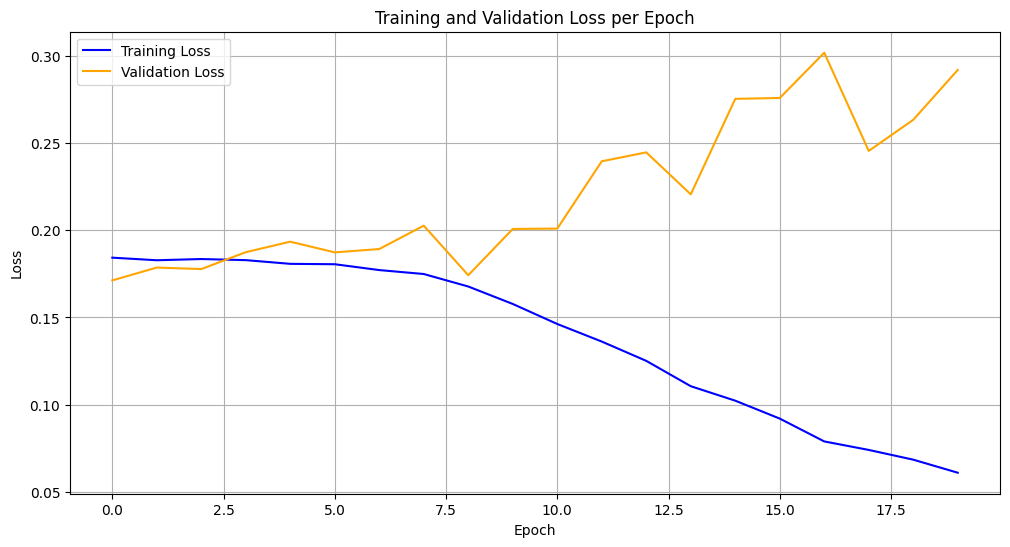

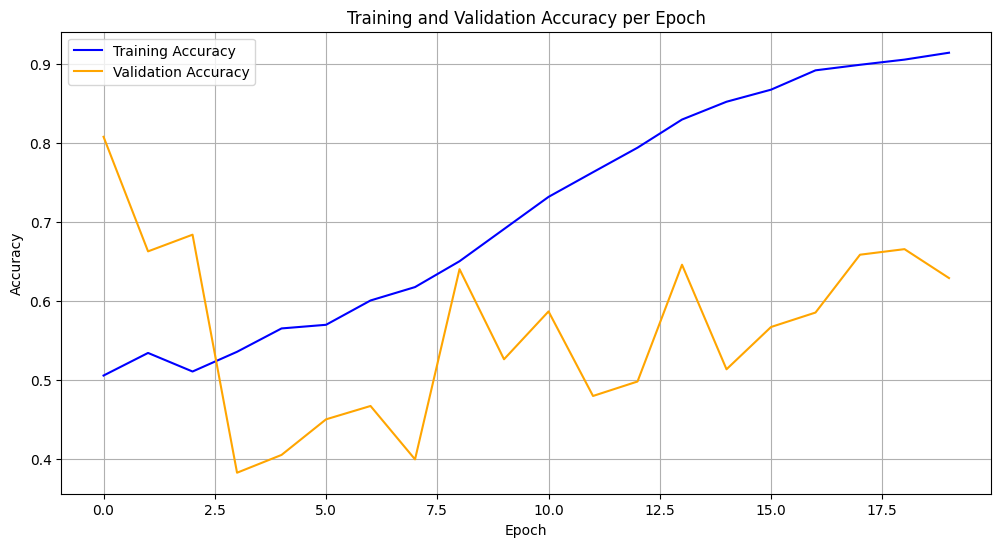

In [56]:
train_model(CNN2DLSTM_v3, train_loader, val_loader, output_layers=24, kernel_size=3, dropout_rate=0.5, learning_rate=0.0003, batch_size=bs, num_epoch=20)

tensor(4.8509, dtype=torch.float64)
Epoch 1/20, Train Loss: 1.3606, Val Loss: 1.4080, Train Acc: 0.4761, Val Acc: 0.1791, Train F1: 0.6442, Val F1: 0.3038
Epoch 2/20, Train Loss: 1.3155, Val Loss: 1.6032, Train Acc: 0.5047, Val Acc: 0.1791, Train F1: 0.6709, Val F1: 0.3038
Epoch 3/20, Train Loss: 1.2956, Val Loss: 1.4432, Train Acc: 0.5030, Val Acc: 0.2003, Train F1: 0.6691, Val F1: 0.3094
Epoch 4/20, Train Loss: 1.2416, Val Loss: 1.4924, Train Acc: 0.5091, Val Acc: 0.2384, Train F1: 0.6692, Val F1: 0.3147
Epoch 5/20, Train Loss: 1.0598, Val Loss: 1.8030, Train Acc: 0.5963, Val Acc: 0.2539, Train F1: 0.7112, Val F1: 0.2899
Epoch 6/20, Train Loss: 0.8666, Val Loss: 1.6699, Train Acc: 0.7138, Val Acc: 0.3695, Train F1: 0.7755, Val F1: 0.2732
Epoch 7/20, Train Loss: 0.6474, Val Loss: 2.2836, Train Acc: 0.8029, Val Acc: 0.4922, Train F1: 0.8375, Val F1: 0.2308
Epoch 8/20, Train Loss: 0.5375, Val Loss: 2.5753, Train Acc: 0.8485, Val Acc: 0.5698, Train F1: 0.8636, Val F1: 0.2394
Epoch 9/20, 

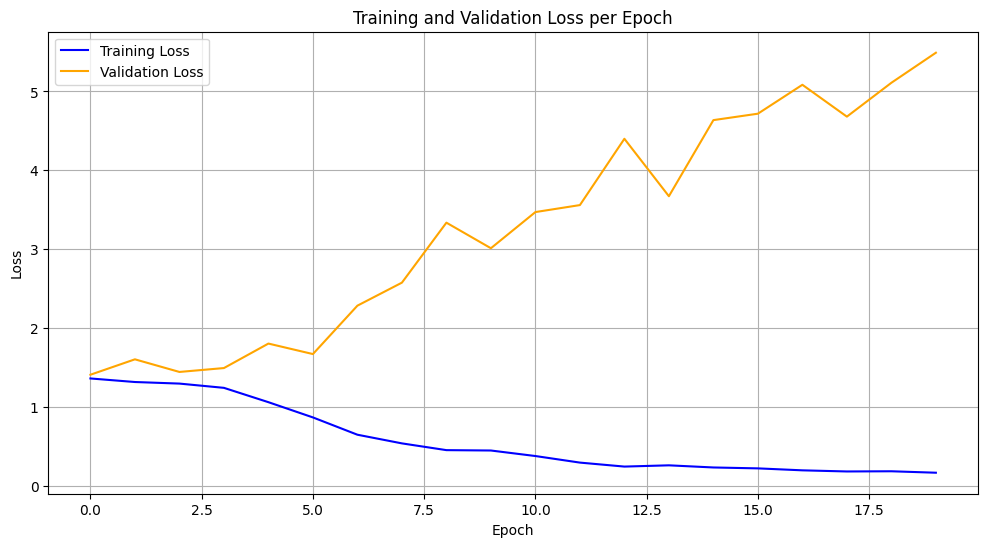

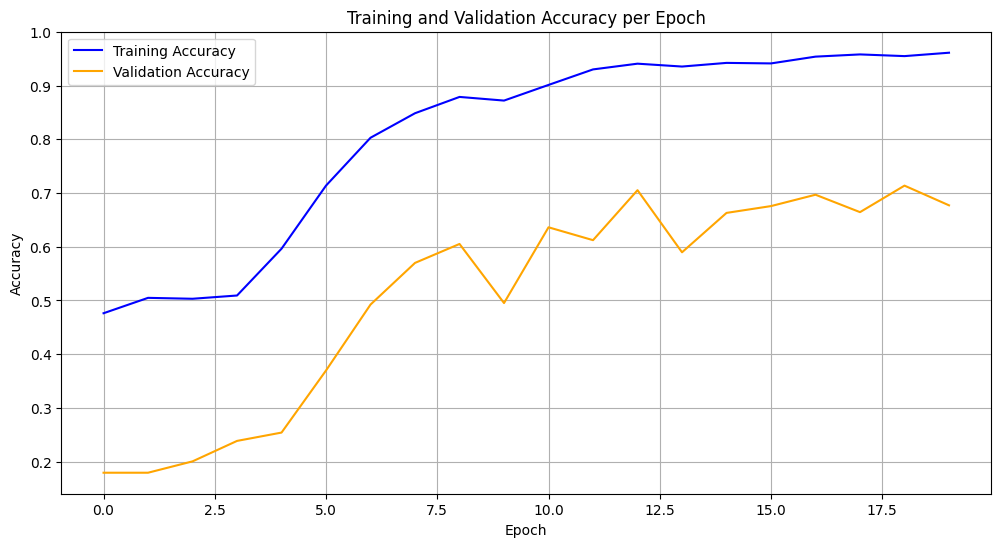

In [20]:
train_model(CNN2DLSTM_v3, train_loader, val_loader, output_layers=16, kernel_size=3, dropout_rate=0.5, learning_rate=0.0005, batch_size=bs, num_epoch=20)

tensor(4.8509, dtype=torch.float64)
Epoch 1/20, Train Loss: 1.3594, Val Loss: 1.5452, Train Acc: 0.4999, Val Acc: 0.1791, Train F1: 0.6665, Val F1: 0.3038
Epoch 2/20, Train Loss: 1.3344, Val Loss: 1.6737, Train Acc: 0.5040, Val Acc: 0.1791, Train F1: 0.6702, Val F1: 0.3038
Epoch 3/20, Train Loss: 1.3286, Val Loss: 1.6382, Train Acc: 0.5038, Val Acc: 0.1791, Train F1: 0.6700, Val F1: 0.3038
Epoch 4/20, Train Loss: 1.3369, Val Loss: 1.5666, Train Acc: 0.4909, Val Acc: 0.1791, Train F1: 0.6585, Val F1: 0.3038
Epoch 5/20, Train Loss: 1.3328, Val Loss: 1.5784, Train Acc: 0.4982, Val Acc: 0.1791, Train F1: 0.6650, Val F1: 0.3038
Epoch 6/20, Train Loss: 1.3206, Val Loss: 1.6186, Train Acc: 0.5047, Val Acc: 0.1791, Train F1: 0.6709, Val F1: 0.3038
Epoch 7/20, Train Loss: 1.2940, Val Loss: 1.5258, Train Acc: 0.4972, Val Acc: 0.1791, Train F1: 0.6641, Val F1: 0.3038
Epoch 8/20, Train Loss: 1.2757, Val Loss: 1.6124, Train Acc: 0.5057, Val Acc: 0.1791, Train F1: 0.6715, Val F1: 0.3038
Epoch 9/20, 

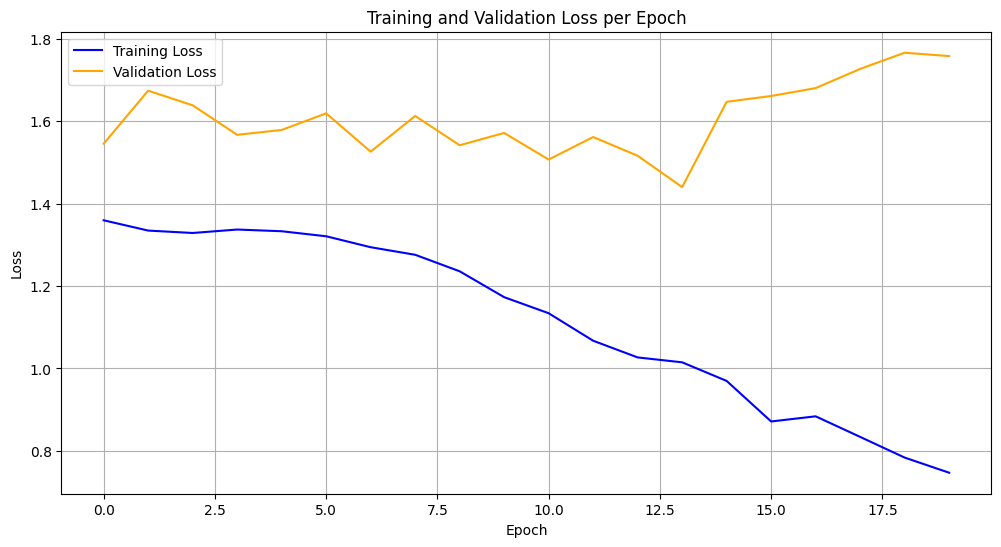

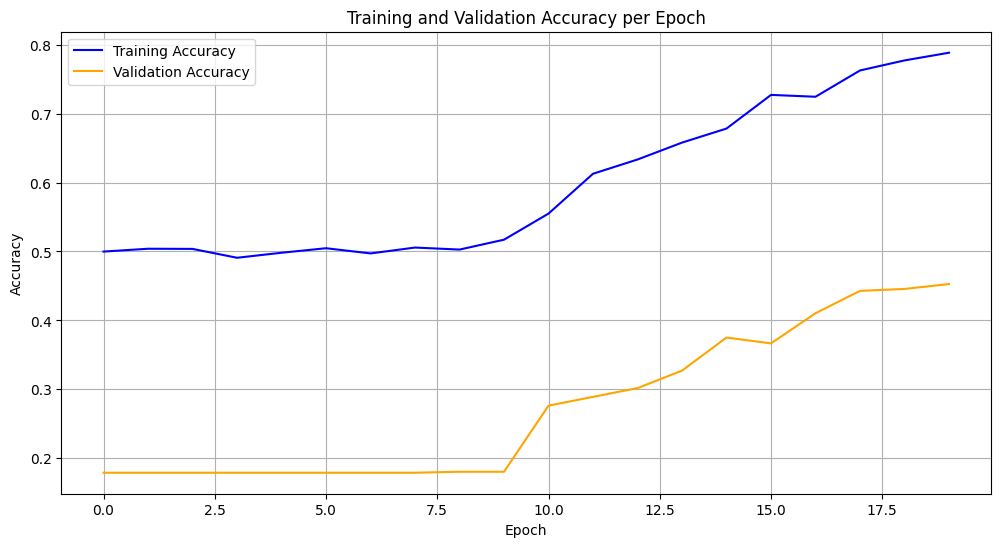

In [28]:
train_model(CNN2DLSTM_v3, train_loader, val_loader, output_layers=16, kernel_size=3, dropout_rate=0.5, learning_rate=0.0005, batch_size=bs, num_epoch=20)

tensor(4.8509, dtype=torch.float64)
Epoch 1/20, Train Loss: 1.7945, Val Loss: 1.2464, Train Acc: 0.4926, Val Acc: 0.1805, Train F1: 0.6498, Val F1: 0.3042
Epoch 2/20, Train Loss: 1.5529, Val Loss: 1.3095, Train Acc: 0.4958, Val Acc: 0.1791, Train F1: 0.6627, Val F1: 0.3038
Epoch 3/20, Train Loss: 1.3643, Val Loss: 1.3896, Train Acc: 0.5004, Val Acc: 0.1791, Train F1: 0.6669, Val F1: 0.3038
Epoch 4/20, Train Loss: 1.2655, Val Loss: 1.3755, Train Acc: 0.4953, Val Acc: 0.1791, Train F1: 0.6624, Val F1: 0.3038
Epoch 5/20, Train Loss: 1.1877, Val Loss: 1.4014, Train Acc: 0.5101, Val Acc: 0.1791, Train F1: 0.6756, Val F1: 0.3038
Epoch 6/20, Train Loss: 1.1011, Val Loss: 1.3631, Train Acc: 0.4899, Val Acc: 0.1791, Train F1: 0.6565, Val F1: 0.3038
Epoch 7/20, Train Loss: 0.9739, Val Loss: 1.3501, Train Acc: 0.5154, Val Acc: 0.1805, Train F1: 0.6748, Val F1: 0.3042
Epoch 8/20, Train Loss: 0.8902, Val Loss: 1.2763, Train Acc: 0.5409, Val Acc: 0.2073, Train F1: 0.6850, Val F1: 0.3027
Epoch 9/20, 

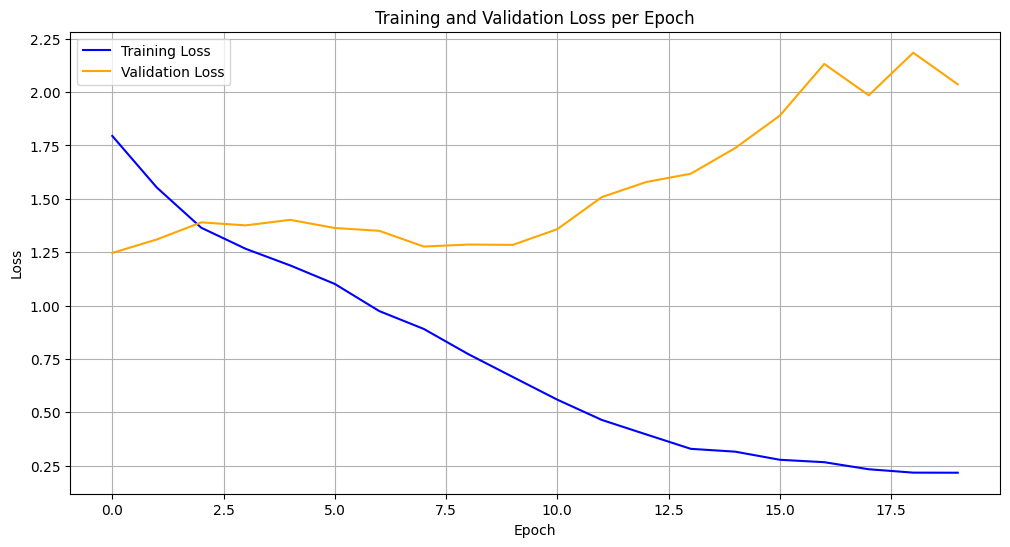

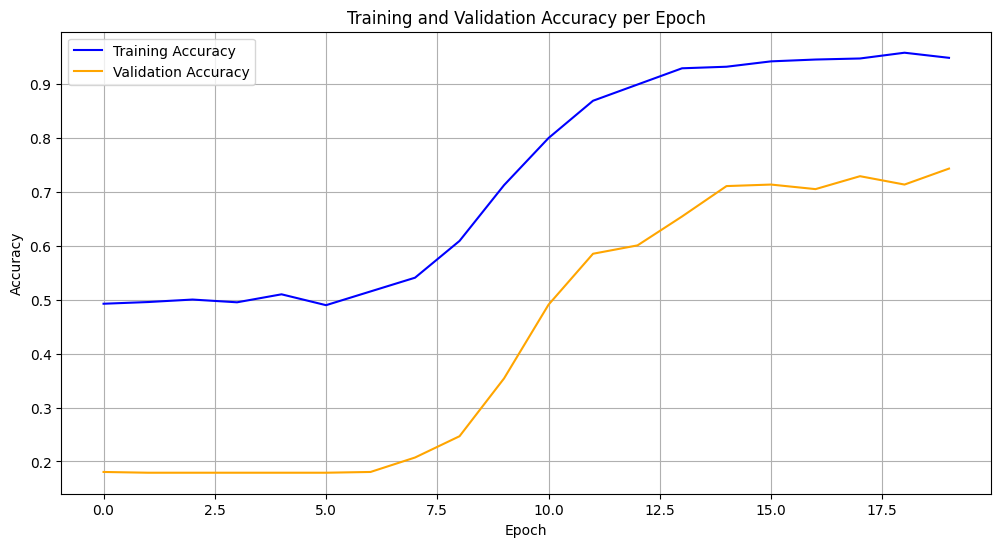

In [30]:
train_model(CNN2DLSTM, train_loader, val_loader, output_layers=32, kernel_size=3, dropout_rate=0.5, learning_rate=0.0001, batch_size=32, num_epoch=20)

tensor(4.8509, dtype=torch.float64)
Epoch 1/20, Train Loss: 1.4792, Val Loss: 1.5643, Train Acc: 0.4996, Val Acc: 0.1791, Train F1: 0.6615, Val F1: 0.3038
Epoch 2/20, Train Loss: 1.3404, Val Loss: 1.5700, Train Acc: 0.5103, Val Acc: 0.1791, Train F1: 0.6758, Val F1: 0.3038
Epoch 3/20, Train Loss: 1.3318, Val Loss: 1.5847, Train Acc: 0.5159, Val Acc: 0.1791, Train F1: 0.6807, Val F1: 0.3038
Epoch 4/20, Train Loss: 1.3415, Val Loss: 1.5042, Train Acc: 0.5006, Val Acc: 0.1791, Train F1: 0.6672, Val F1: 0.3038
Epoch 5/20, Train Loss: 1.3441, Val Loss: 1.5451, Train Acc: 0.4933, Val Acc: 0.1791, Train F1: 0.6607, Val F1: 0.3038
Epoch 6/20, Train Loss: 1.3166, Val Loss: 1.4565, Train Acc: 0.5091, Val Acc: 0.1791, Train F1: 0.6747, Val F1: 0.3038
Epoch 7/20, Train Loss: 1.2968, Val Loss: 1.5110, Train Acc: 0.5016, Val Acc: 0.1791, Train F1: 0.6681, Val F1: 0.3038
Epoch 8/20, Train Loss: 1.2420, Val Loss: 1.4234, Train Acc: 0.5011, Val Acc: 0.1791, Train F1: 0.6675, Val F1: 0.3038
Epoch 9/20, 

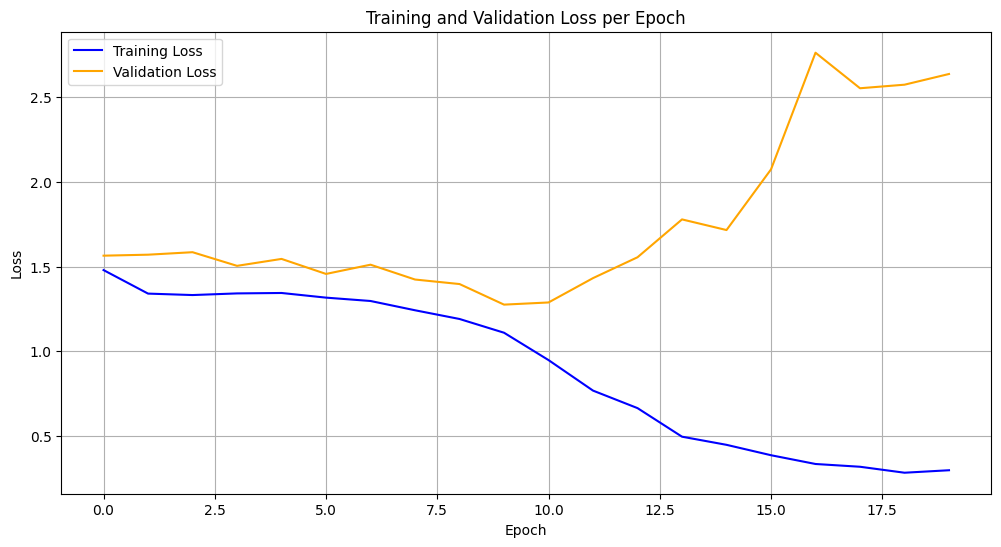

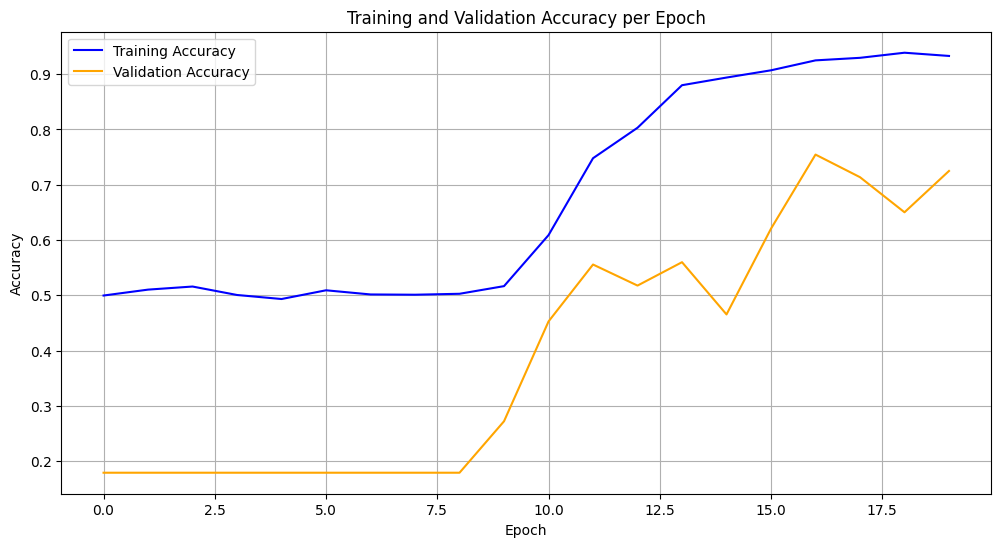

In [184]:
train_model(ResNetLSTM, train_loader, val_loader, output_layers=16, kernel_size=3, dropout_rate=0.5, learning_rate=0.0001, batch_size=32, num_epoch=20)

tensor(4.8509, dtype=torch.float64)
Epoch 1/20, Train Loss: 1.9415, Val Loss: 1.2970, Train Acc: 0.5013, Val Acc: 0.1791, Train F1: 0.4728, Val F1: 0.3038
Epoch 2/20, Train Loss: 1.3595, Val Loss: 1.5626, Train Acc: 0.4996, Val Acc: 0.1791, Train F1: 0.6663, Val F1: 0.3038
Epoch 3/20, Train Loss: 1.3524, Val Loss: 1.5546, Train Acc: 0.4916, Val Acc: 0.1791, Train F1: 0.6592, Val F1: 0.3038
Epoch 4/20, Train Loss: 1.3377, Val Loss: 1.5376, Train Acc: 0.5013, Val Acc: 0.1791, Train F1: 0.6679, Val F1: 0.3038
Epoch 5/20, Train Loss: 1.3358, Val Loss: 1.5327, Train Acc: 0.5042, Val Acc: 0.1791, Train F1: 0.6704, Val F1: 0.3038
Epoch 6/20, Train Loss: 1.3336, Val Loss: 1.5639, Train Acc: 0.4994, Val Acc: 0.1791, Train F1: 0.6661, Val F1: 0.3038
Epoch 7/20, Train Loss: 1.3297, Val Loss: 1.5597, Train Acc: 0.5115, Val Acc: 0.1791, Train F1: 0.6768, Val F1: 0.3038
Epoch 8/20, Train Loss: 1.3270, Val Loss: 1.5996, Train Acc: 0.4955, Val Acc: 0.1791, Train F1: 0.6627, Val F1: 0.3038
Epoch 9/20, 

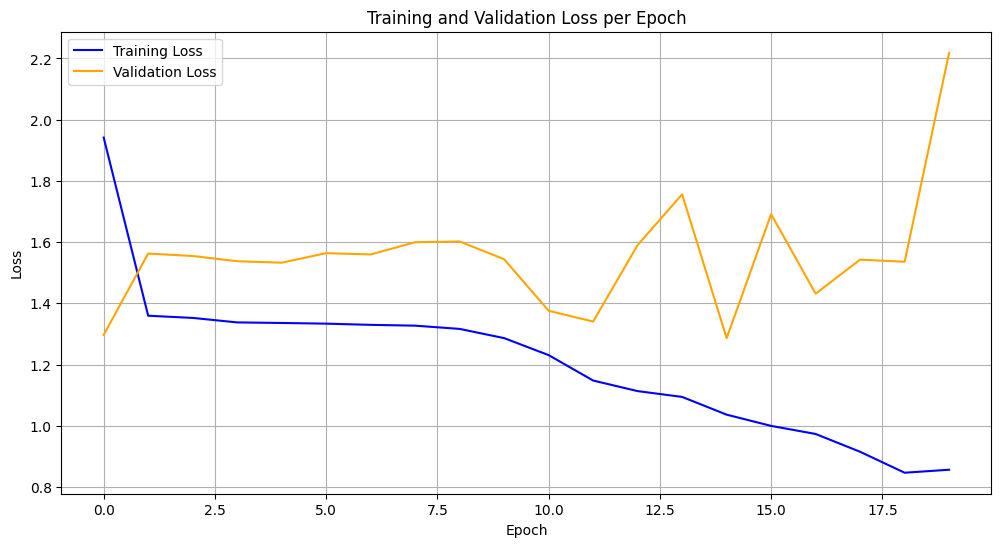

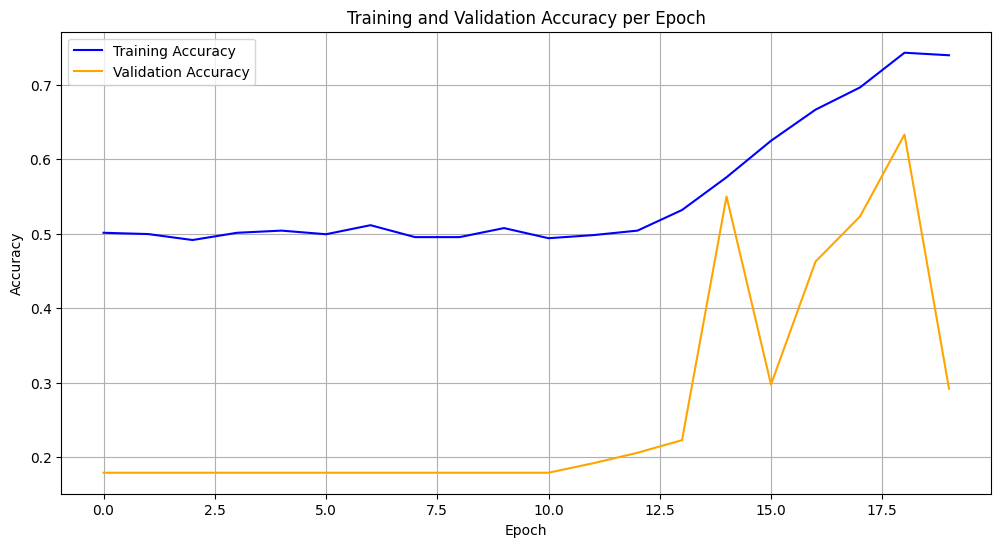

In [191]:
train_model(CNNLSTM4, train_loader, val_loader, output_layers=32, kernel_size=3, dropout_rate=0.5, learning_rate=0.0001, batch_size=32, num_epoch=20)

In [ ]:
train_model(CNNLSTM1, train_dataset, val_dataset, output_layers=32, kernel_size=3, dropout_rate=0.5, learning_rate=0.05, batch_size=32, num_epoch=50)

### Hyperparameter Tuning

In [93]:
search = {
    'model': [CNN2DLSTM_v3, CNN2DLSTM_v4, CNN2DLSTM],
    'output_layers': [16, 24, 32],
    'kernel_size': [3, 5, 7],
    'dropout_rate': [0.2, 0.5, 0.7],
    'learning_rate': list(np.logspace(np.log10(1e-5), np.log10(1e-2), num=100)),
    'batch_size': [8, 16, 32, 64],
    'num_epoch' : [20, 30, 40],
    'threshold': [0.2, 0.4, 0.5, 0.6, 0.7]
}

In [92]:
def random_search(train_dataset, val_dataset, param, num_trials):
    top_models = []

    for trial in range(num_trials):
        params = {k: random.sample(v, 1)[0] for k, v in param.items()}
        
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model_class = params['model']
        bs = params['batch_size']

        weights = train_dataset.weights
        sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=False, sampler=sampler)
        val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

        true, prob, preds = train_model(
            model_class,
            train_loader,
            val_loader,
            output_layers=params['output_layers'],
            kernel_size=3,
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            batch_size=bs,
            num_epoch=params['num_epoch'],
            threshold=params['threshold']
        )
        
        f1 = f1_score(true, preds)
        auroc = roc_auc_score(true, prob)

        score = 0.5 * auroc + 0.5 * f1
        top_models.append((params, f1, auroc, score))
        print(f"Completed model {trial}/{num_trials}, {model_class}, f1: {f1}, auroc: {auroc}, lr: {params['learning_rate']}")

    top_models.sort(key=lambda x: x[3], reverse=True)
    return top_models

In [96]:
top_models = random_search(train_dataset, val_dataset, search, 50)
print("________Top Models_________")
for m in top_models:
    print(m)

Completed model 0/50, <class '__main__.CNN2DLSTM_v4'>, f1: 0.3038277511961723, auroc: 0.5376653949184187, lr: 1.873817422860383e-05
Completed model 1/50, <class '__main__.CNN2DLSTM'>, f1: 0.23952095808383234, auroc: 0.54379413913467, lr: 1.4174741629268048e-05
Completed model 2/50, <class '__main__.CNN2DLSTM_v4'>, f1: 0.23577235772357724, auroc: 0.5617339069729685, lr: 8.111308307896872e-05
Completed model 3/50, <class '__main__.CNN2DLSTM'>, f1: 0.28115015974440893, auroc: 0.4778255810807154, lr: 6.579332246575681e-05
Completed model 4/50, <class '__main__.CNN2DLSTM_v4'>, f1: 0.3038277511961723, auroc: 0.5345807289552724, lr: 1.3219411484660286e-05
Completed model 5/50, <class '__main__.CNN2DLSTM_v3'>, f1: 0.26635514018691586, auroc: 0.527694347484915, lr: 0.00032745491628777284
Completed model 6/50, <class '__main__.CNN2DLSTM_v4'>, f1: 0.19730941704035876, auroc: 0.5308872473415049, lr: 0.0013219411484660286
Completed model 7/50, <class '__main__.CNN2DLSTM_v3'>, f1: 0.3038277511961723

In [1]:
weights = train_dataset.weights
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

bs = 8
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=False, num_workers=0, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=0)
train_model(CNN2DLSTM_v4, train_loader, val_loader, output_layers=24, kernel_size=5, dropout_rate=0.2, learning_rate=0.0002, batch_size=bs, num_epoch=20, threshold=0.2)

NameError: name 'train_dataset' is not defined